c:\Users\nikhi\anaconda3\envs\fbprophet_dep\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Mean Squared Error: 12.660990613615395
Mean Absolute Error: 2.8735821020406127
Root Mean Squared Error: 3.558228578044895


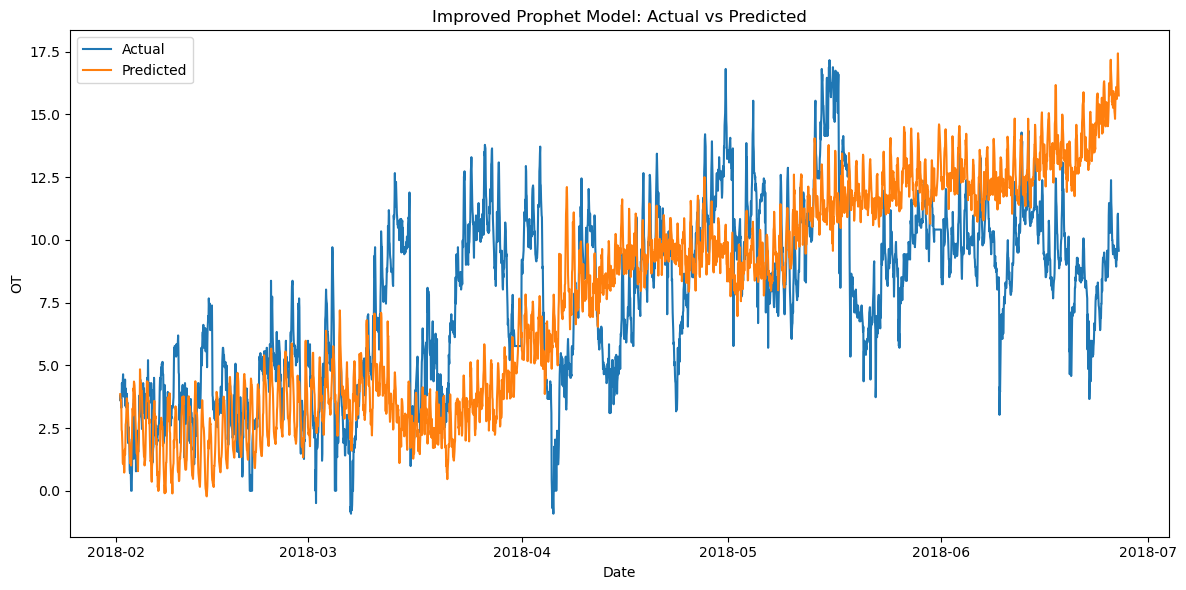

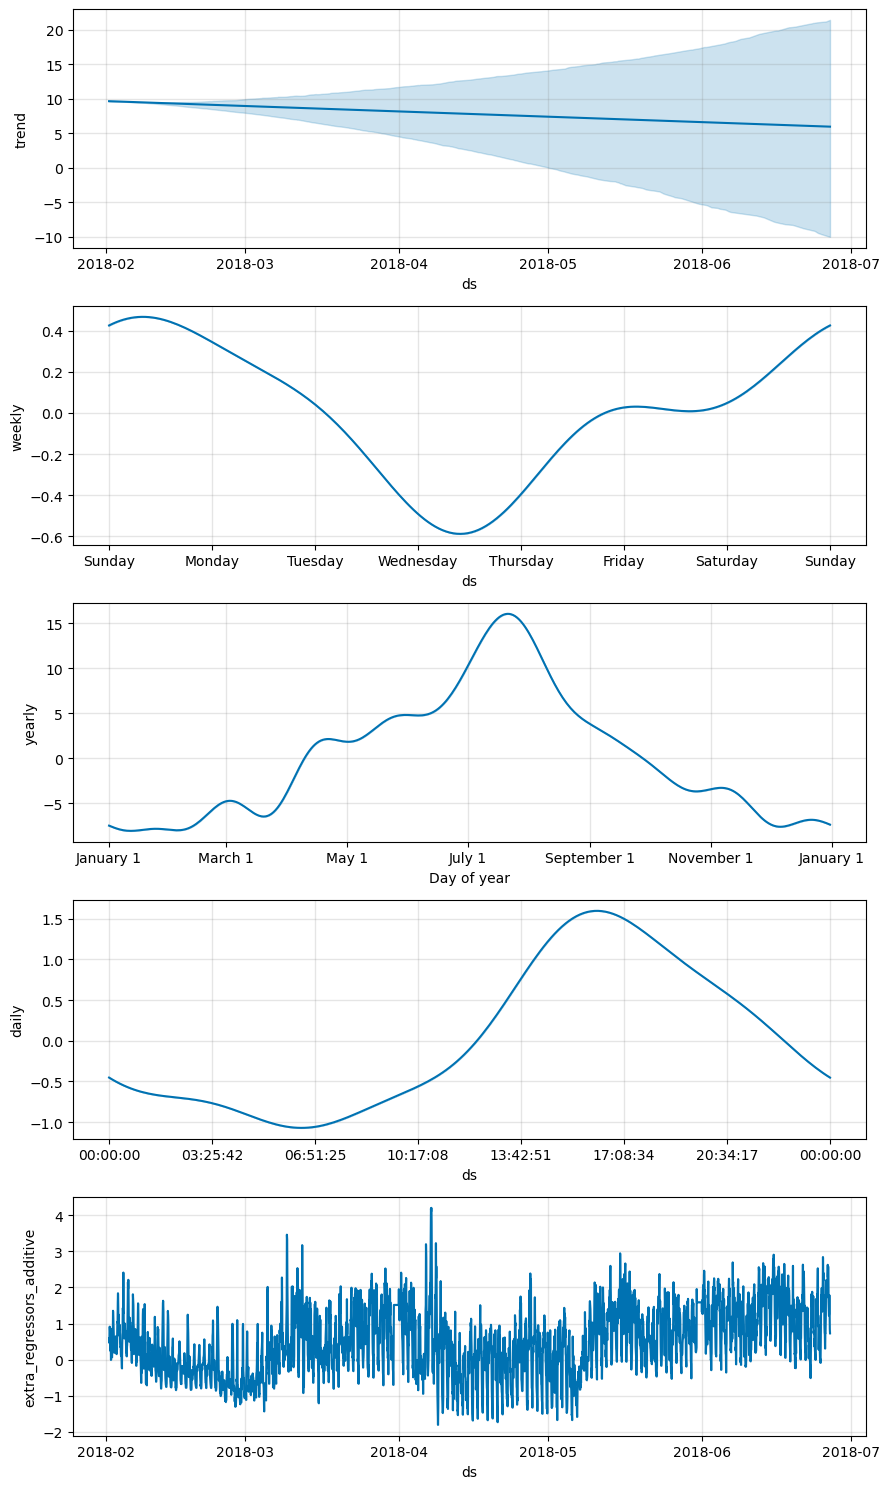

INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-04-07 15:00:00 and 2017-12-03 15:00:00


Cross-validation parameters:
Initial: 241 days
Period: 120 days
Horizon: 60 days


100%|██████████| 3/3 [02:42<00:00, 54.13s/it]
INFO:fbprophet:Skipping MAPE because y close to 0



Cross-validation performance:
              horizon           mse        rmse         mae     mdape  \
0     6 days 00:00:00     43.556229    6.599714    4.674995  0.301036   
1     6 days 01:00:00     45.202214    6.723259    4.741489  0.302412   
2     6 days 02:00:00     46.875986    6.846604    4.808166  0.305815   
3     6 days 03:00:00     48.591851    6.970786    4.877550  0.310607   
4     6 days 04:00:00     50.115577    7.079236    4.938901  0.311334   
...               ...           ...         ...         ...       ...   
1292 59 days 20:00:00  65855.778812  256.623808  158.948157  4.099461   
1293 59 days 21:00:00  65562.594797  256.051938  158.612990  4.093412   
1294 59 days 22:00:00  65267.903844  255.475838  158.271299  4.085535   
1295 59 days 23:00:00  64974.093204  254.900163  157.927156  4.073614   
1296 60 days 00:00:00  64680.395070  254.323406  157.583531  4.019984   

      coverage  
0     0.543981  
1     0.541667  
2     0.539352  
3     0.537037  
4     0

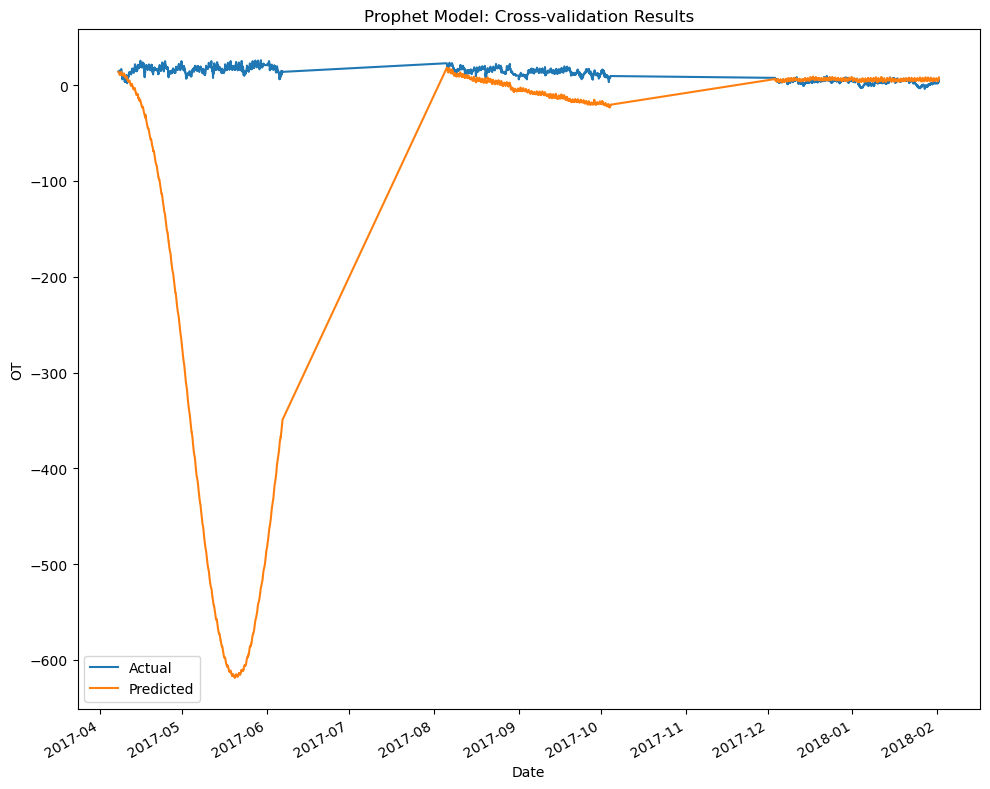

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation, performance_metrics

# Load the preprocessed data
df = pd.read_csv('ett.csv', parse_dates=['date'])

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_data = df[['date', 'OT']].rename(columns={'date': 'ds', 'OT': 'y'})

# Add additional regressors
prophet_data['HUFL'] = df['HUFL']
prophet_data['HULL'] = df['HULL']
prophet_data['MUFL'] = df['MUFL']
prophet_data['MULL'] = df['MULL']
prophet_data['LUFL'] = df['LUFL']
prophet_data['LULL'] = df['LULL']

# Split the data into train and test sets
train_size = int(len(prophet_data) * 0.8)
train = prophet_data[:train_size]
test = prophet_data[train_size:]

# Create and fit Prophet model with additional regressors
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
)
for column in ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']:
    model.add_regressor(column)

model.fit(train)

# Make predictions
future = test[['ds', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']]
forecast = model.predict(future)

# Extract predictions for the test period
predictions = forecast['yhat']

# Evaluate the model
mse = mean_squared_error(test['y'], predictions)
mae = mean_absolute_error(test['y'], predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], predictions, label='Predicted')
plt.title('Improved Prophet Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Prophet's components
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Determine appropriate cross-validation parameters
data_range = (prophet_data['ds'].max() - prophet_data['ds'].min()).days
initial = f'{data_range // 3} days'
period = f'{data_range // 6} days'
horizon = f'{data_range // 12} days'

print(f"Cross-validation parameters:")
print(f"Initial: {initial}")
print(f"Period: {period}")
print(f"Horizon: {horizon}")

# Perform cross-validation with adjusted parameters
cv_results = cross_validation(model, initial=initial, period=period, horizon=horizon)
cv_performance = performance_metrics(cv_results)
print("\nCross-validation performance:")
print(cv_performance)

# Plot cross-validation results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cv_results.plot(x='ds', y='y', ax=ax, label='Actual')
cv_results.plot(x='ds', y='yhat', ax=ax, label='Predicted')
plt.title('Prophet Model: Cross-validation Results')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.tight_layout()
plt.show()